# Détection d'armes dans les bagages à rayons X avec YOLOv11 (SIXray – Roboflow)

## Contexte

Dans les aéroports, les bagages sont scannés par des systèmes de rayons X.
Actuellement, la détection d'objets dangereux (armes à feu, couteaux, etc.) est
principalement réalisée par des opérateurs humains, ce qui peut entraîner des erreurs,
de la fatigue et des coûts élevés.

Dans ce projet, nous entraînons un modèle de vision par ordinateur basé sur **YOLOv11**
pour détecter des objets dangereux dans des images de bagages scannés aux rayons X,
à partir du dataset **SIXray** disponible sur **Roboflow**.

Ce notebook couvre :

1. Téléchargement et préparation du dataset (via Roboflow)
2. Analyse exploratoire des données (EDA)
3. Entraînement d’un modèle YOLOv11
4. Visualisation des courbes d’entraînement (loss, métriques)
5. Évaluation du modèle sur le jeu de test
6. Visualisation de prédictions sur quelques images
7. Sauvegarde du modèle pour un futur déploiement (API Flask + Docker + EC2)

L’objectif final est d’intégrer ce modèle dans un pipeline DevOps/MLOps avec API Flask, Docker, GitHub Actions et EC2.


## 0. Téléchargement et importation des dépendances

In [1]:
!pip install ultralytics roboflow matplotlib pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 117.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [2]:
import os
from pathlib import Path
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from roboflow import Roboflow
from ultralytics import YOLO

# Pour un affichage plus joli
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8, 5)

# Fixer une seed pour la reproductibilité (partielle)
random.seed(42)
np.random.seed(42)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device :", DEVICE)

Device : cuda


In [4]:
from IPython.display import display as ipy_display

def display_no_index(obj):
    if isinstance(obj, pd.DataFrame):
        return ipy_display(obj.style.hide(axis="index"))
    return ipy_display(obj)

globals()['display'] = display_no_index

## 1. Télechargement et preéparation du dataet

In [5]:
from roboflow import Roboflow
rf = Roboflow(api_key="gr2zKFJrOHfVeKa4ODMr")
project = rf.workspace("siewchinyip-outlook-my").project("sixray")
version = project.version(4)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Sixray-4 in yolov11:: 100%|██████████| 16636/16636 [00:02<00:00, 8011.01it/s]


## 2. Analyse exploratoire des données (EDA)

Vérification de la structure du dataset puis affichage des différentes classes présentes dans le dataset

In [6]:
import yaml

data_yaml_path = next(Path(".").rglob("data.yaml"))
print("Chemin du data.yaml :", data_yaml_path)

with open(data_yaml_path, "r") as f:
    data_cfg = yaml.safe_load(f)

print("Configuration dataset :")
print(data_cfg)

class_names = data_cfg.get("names", [])
num_classes = data_cfg.get("nc", len(class_names))

print("\nNombre de classes :", num_classes)
print("Liste des classes :", class_names)

Chemin du data.yaml : Sixray-4/data.yaml
Configuration dataset :
{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 5, 'names': ['Gun', 'Knife', 'Pliers', 'Scissors', 'Wrench'], 'roboflow': {'workspace': 'siewchinyip-outlook-my', 'project': 'sixray', 'version': 4, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/siewchinyip-outlook-my/sixray/dataset/4'}}

Nombre de classes : 5
Liste des classes : ['Gun', 'Knife', 'Pliers', 'Scissors', 'Wrench']


Vérification de la répartition des images

In [23]:
dataset_root = Path(data_yaml_path).parent
print("Racine du dataset :", dataset_root)

splits = ["train", "valid", "test"]
image_extensions = [".jpg", ".jpeg", ".png"]

split_counts = {}

for split in splits:
    split_dir = dataset_root / split / "images"
    if not split_dir.exists():
        print(f"⚠ Dossier images pour {split} introuvable :", split_dir)
        continue

    image_files = []
    for ext in image_extensions:
        image_files.extend(split_dir.rglob(f"*{ext}"))

    split_counts[split] = len(image_files)
    print(f"{split} : {len(image_files)} images")

split_counts

Racine du dataset : Sixray-4
train : 5819 images
valid : 1662 images
test : 831 images


{'train': 5819, 'valid': 1662, 'test': 831}

Affichage de la distribution des différentes classes

In [8]:
from collections import Counter

class_counts = Counter()

for split in splits:
    labels_dir = dataset_root / split / "labels"
    if not labels_dir.exists():
        continue

    label_files = list(labels_dir.rglob("*.txt"))
    for lf in label_files:
        with open(lf, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 0:
                    continue
                cls_id = int(parts[0])
                class_counts[cls_id] += 1

print("Occurrences par ID de classe :", class_counts)

# Convertir en DataFrame pour affichage
rows = []
for cls_id, count in class_counts.items():
    cls_name = class_names[cls_id] if cls_id < len(class_names) else f"cls_{cls_id}"
    rows.append({"class_id": cls_id, "class_name": cls_name, "count": count})

df_classes = pd.DataFrame(rows).sort_values("count", ascending=False)
df_classes

Occurrences par ID de classe : Counter({2: 5314, 0: 4386, 4: 2779, 1: 2084, 3: 1105})


,class_id,class_name,count
1,2,Pliers,5314
0,0,Gun,4386
2,4,Wrench,2779
3,1,Knife,2084
4,3,Scissors,1105


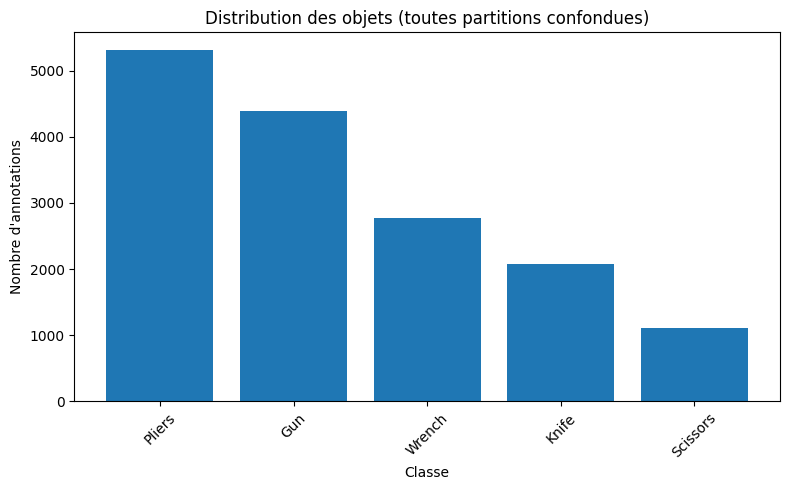

In [9]:
plt.figure(figsize=(8, 5))
plt.bar(df_classes["class_name"], df_classes["count"])
plt.title("Distribution des objets (toutes partitions confondues)")
plt.xlabel("Classe")
plt.ylabel("Nombre d'annotations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Visualisation de quelques images présentes dans le dataset

Nombre d'images train trouvées : 5819


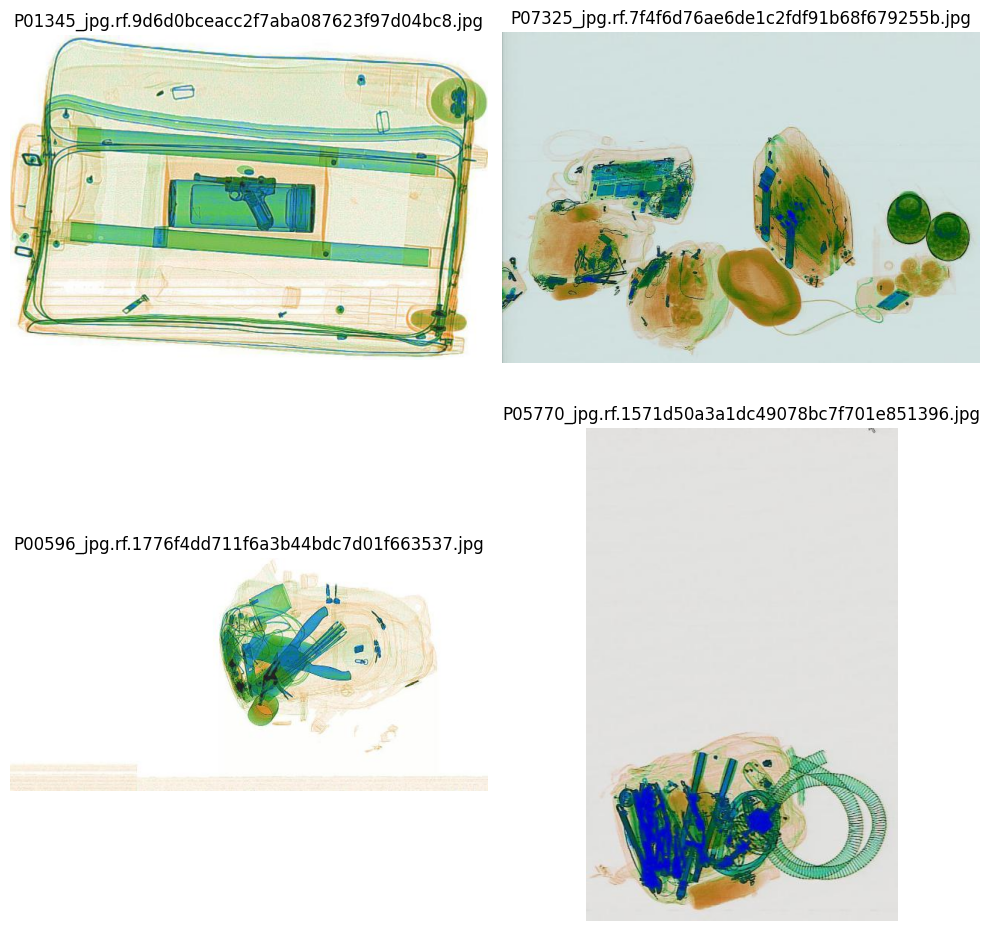

In [10]:
import cv2

train_images_dir = dataset_root / "train" / "images"
all_train_images = list(train_images_dir.rglob("*.jpg"))
if len(all_train_images) == 0:
    all_train_images = list(train_images_dir.rglob("*.png"))

print(f"Nombre d'images train trouvées : {len(all_train_images)}")

sample_images = random.sample(all_train_images, k=min(4, len(all_train_images)))

plt.figure(figsize=(10, 10))
for i, img_path in enumerate(sample_images, 1):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 2, i)
    plt.imshow(img)
    plt.title(img_path.name)
    plt.axis("off")
plt.tight_layout()
plt.show()

## 3. Entraînement d’un modèle YOLOv11

Sélection du model de base et initialisation des hyper-parametres

In [11]:
base_model_name = "yolo11m.pt"

data_path = str(data_yaml_path)

EPOCHS = 50
IMG_SIZE = 640
BATCH_SIZE = 16

print("Modèle de base :", base_model_name)
print("Fichier data.yaml :", data_path)
print("Epochs :", EPOCHS, "| img size :", IMG_SIZE, "| batch size :", BATCH_SIZE)

Modèle de base : yolo11m.pt
Fichier data.yaml : Sixray-4/data.yaml
Epochs : 50 | img size : 640 | batch size : 16


Lancement de la phase d'entrainement !

In [12]:
model = YOLO(base_model_name)

results = model.train(
    data=data_path,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    project="runs_sixray",
    name="yolo11m_sixray",
)

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Sixray-4/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11m_sixray, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12

L'entrainement s'est déroulé sur 50 epochs et a duré 3.203 hours.

## 4. Visualisation des courbes d’entraînement (loss, métriques)


In [13]:
run_dir = Path("runs_sixray") / "yolo11m_sixray"
print("Répertoire du run :", run_dir)

results_png = run_dir / "results.png"
print("Courbes sauvegardées dans :", results_png)


Répertoire du run : runs_sixray/yolo11m_sixray
Courbes sauvegardées dans : runs_sixray/yolo11m_sixray/results.png


In [14]:
results_csv = run_dir / "results.csv"
print("Fichier results.csv :", results_csv)

df_results = pd.read_csv(results_csv)
df_results.head()

Fichier results.csv : runs_sixray/yolo11m_sixray/results.csv


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,293.138,1.88234,2.28759,1.86003,0.40929,0.38435,0.35890,0.15799,1.90053,2.03363,2.07413,0.000369,0.000369,0.000369
1,2,521.594,1.93236,2.09501,1.96600,0.53303,0.35408,0.35231,0.16132,1.95651,2.70760,2.13859,0.000725,0.000725,0.000725
2,3,746.954,1.90438,2.05607,1.96042,0.46913,0.47986,0.44939,0.20555,1.81729,2.04111,2.04564,0.001066,0.001066,0.001066
3,4,971.486,1.82859,1.91678,1.89518,0.53060,0.46892,0.46959,0.22465,1.75204,1.86319,1.97742,0.001045,0.001045,0.001045
4,5,1198.580,1.76048,1.78058,1.84597,0.65034,0.52176,0.58679,0.29939,1.69421,1.43491,1.88470,0.001023,0.001023,0.001023


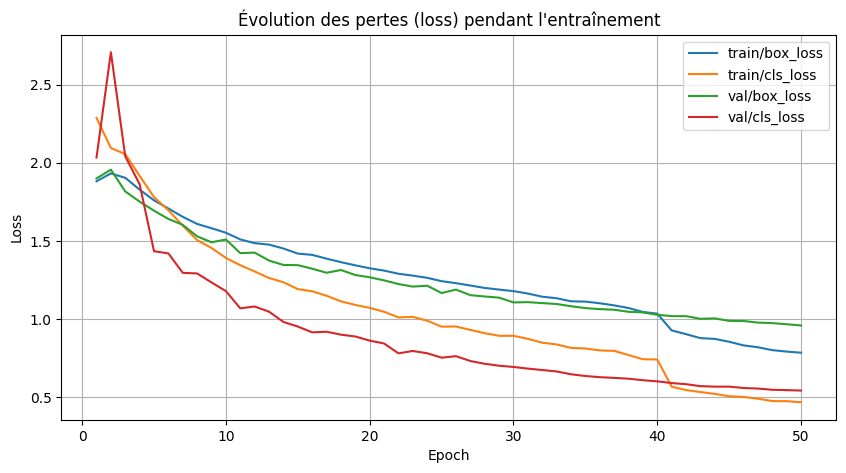

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(df_results["epoch"], df_results["train/box_loss"], label="train/box_loss")
plt.plot(df_results["epoch"], df_results["train/cls_loss"], label="train/cls_loss")
plt.plot(df_results["epoch"], df_results["val/box_loss"], label="val/box_loss")
plt.plot(df_results["epoch"], df_results["val/cls_loss"], label="val/cls_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Évolution des pertes (loss) pendant l'entraînement")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df_results.columns

Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

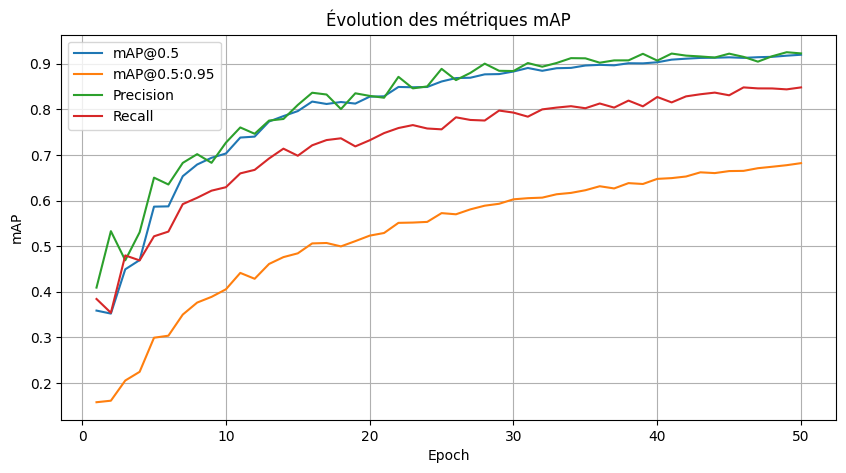

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(df_results["epoch"], df_results["metrics/mAP50(B)"], label="mAP@0.5")
plt.plot(df_results["epoch"], df_results["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")

plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("Évolution des métriques mAP")
plt.legend()
plt.grid(True)
plt.show()


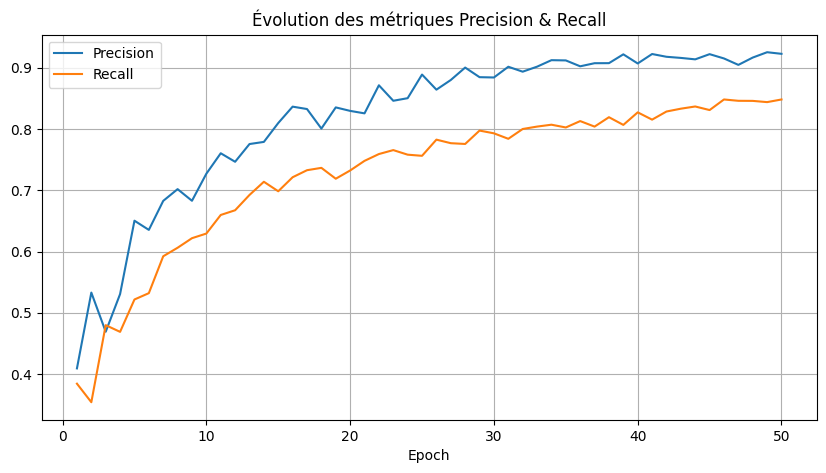

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(df_results["epoch"], df_results["metrics/precision(B)"], label="Precision")
plt.plot(df_results["epoch"], df_results["metrics/recall(B)"], label="Recall")
plt.xlabel("Epoch")
plt.title("Évolution des métriques Precision & Recall")
plt.legend()
plt.grid(True)
plt.show()

## 5. Évaluation du modèle sur le jeu de test

Lancement de l'évaluation sur les données de test !

In [17]:
metrics = model.val(
    data=data_path,
    split="test",
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    project="runs_sixray",
    name="yolo11m_sixray_val"
)

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,033,887 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 20.7±6.2 MB/s, size: 44.9 KB)
val: Scanning /content/Sixray-4/test/labels... 831 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 831/831 646.1it/s 1.3s
val: New cache created: /content/Sixray-4/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 52/52 2.5it/s 20.4s
                   all        831       1593      0.929      0.852      0.917      0.678
                   Gun        288        474      0.976      0.958      0.988      0.773
                 Knife        111        169      0.896      0.781      0.879      0.607
                Pliers        387        524      0.941      0.848      0.925        0.7
              Scissors         97        120      0.928      0.865      0.918     

Récapitulatif des performances globales puis par classes

In [31]:
print("=== RÉCAPITULATIF DES PERFORMANCES GLOBALES ===")

mp, mr, map50, map5095 = metrics.box.mean_results()

print(f"Mean Precision (mp)      : {mp:.4f}")
print(f"Mean Recall (mr)         : {mr:.4f}")
print(f"mAP@0.50 (map50)         : {map50:.4f}")
print(f"mAP@0.50:0.95 (map)      : {map5095:.4f}")

=== RÉCAPITULATIF DES PERFORMANCES GLOBALES ===
Mean Precision (mp)      : 0.9293
Mean Recall (mr)         : 0.8515
mAP@0.50 (map50)         : 0.9173
mAP@0.50:0.95 (map)      : 0.6779


In [32]:
import pandas as pd

class_names = ['Gun', 'Knife', 'Pliers', 'Scissors', 'Wrench']

per_class_data = {
    "class_id": [],
    "class_name": [],
    "precision": [],
    "recall": [],
    "f1_score": [],
    "map": [],
}

for i, name in enumerate(class_names):
    per_class_data["class_id"].append(i)
    per_class_data["class_name"].append(name)
    per_class_data["precision"].append(metrics.box.p[i])
    per_class_data["recall"].append(metrics.box.r[i])
    per_class_data["f1_score"].append(metrics.box.f1[i])
    per_class_data["map"].append(metrics.box.maps[i])

df_per_class = pd.DataFrame(per_class_data)
df_per_class


,class_id,class_name,precision,recall,f1_score,map
0,0,Gun,0.976394,0.957806,0.967011,0.772729
1,1,Knife,0.896326,0.781065,0.834736,0.606632
2,2,Pliers,0.940738,0.848249,0.892103,0.700251
3,3,Scissors,0.928421,0.864716,0.895437,0.659251
4,4,Wrench,0.904620,0.805866,0.852392,0.650715


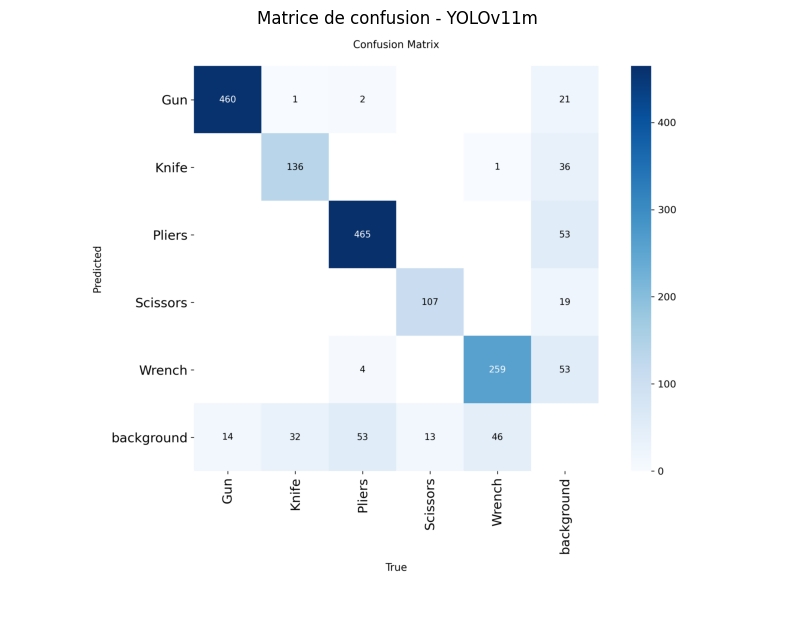

In [34]:
from PIL import Image
import matplotlib.pyplot as plt

cm_path = "/content/runs_sixray/yolo11m_sixray_val/confusion_matrix.png"

img = Image.open(cm_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.title("Matrice de confusion - YOLOv11m")
plt.show()


## 6. Visualisation de prédictions sur quelques images

Chemin du modèle best.pt : runs_sixray/yolo11m_sixray/weights/best.pt
Nombre d'images test : 831


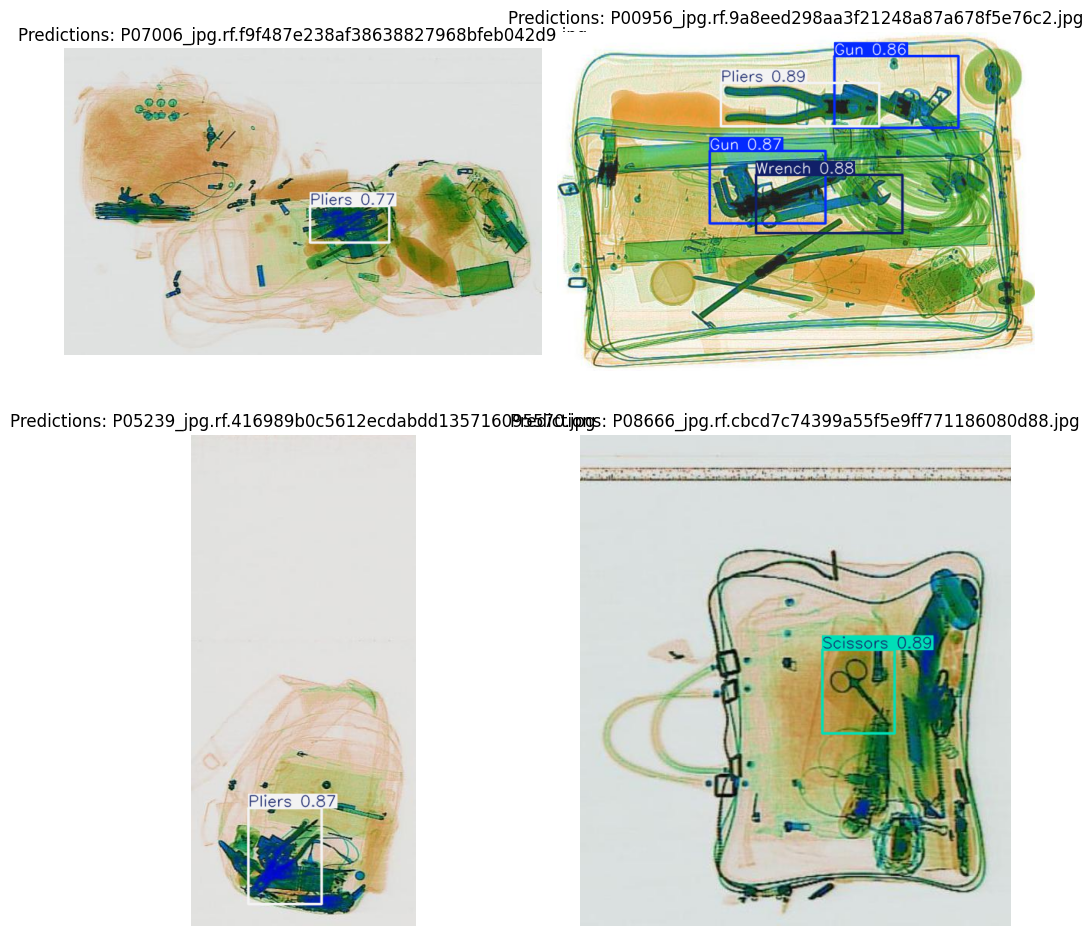

In [46]:
best_weights = run_dir / "weights" / "best.pt"
print("Chemin du modèle best.pt :", best_weights)

trained_model = YOLO(str(best_weights))

test_images_dir = dataset_root / "test" / "images"
test_images = list(test_images_dir.rglob("*.jpg"))
if len(test_images) == 0:
    test_images = list(test_images_dir.rglob("*.png"))

print("Nombre d'images test :", len(test_images))

sample_test_images = random.sample(test_images, k=min(4, len(test_images)))

plt.figure(figsize=(10, 10))
for i, img_path in enumerate(sample_test_images, 1):
    results = trained_model.predict(
        source=str(img_path),
        conf=0.25,
        verbose=False
    )
    # Récupérer l'image annotée (numpy array BGR)
    annotated_img = results[0].plot()
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 2, i)
    plt.imshow(annotated_img)
    plt.title(f"Predictions: {img_path.name}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 7.Sauvegarde du modèle pour un futur déploiement (API Flask + Docker + EC2)


In [44]:
os.makedirs("model", exist_ok=True)

target_path = Path("model/yolo11_sixray_best.pt")

import shutil
shutil.copy(best_weights, target_path)

print("Modèle sauvegardé pour le déploiement dans :", target_path)


Modèle sauvegardé pour le déploiement dans : model/yolo11_sixray_best.pt
